# Analyzing Supreme Court decisions

Background: This notebook analyzes scraped information from the Philippine Supreme Court [website](https://elibrary.judiciary.gov.ph/). Data here was scraped from the website by yearend 2023 and showed decisions **as of Aug. 30, 2023**. Note that some decisions are added belatedly.

The analysis uses a **subset** of the scraped decisions list from the Supreme Court. The scraper can be found on a separate repository located [here](https://github.com/pmagtulis/supremecourt-ph-scraper) and contains decisions from 1996 to present.

The analysis only contains cases from 2013. We filtered the cases at the onset using Excel.

## Do your imports

In [1]:
import pandas as pd
import numpy as np
from plotnine import *
import fuzzy_pandas as fpd
import re

## Read CSV

The file contains the data getting scraped from the Supreme Court website every Sunday.

In [2]:
df= pd.read_excel('2013-2023 decisions.xlsx') 
#this is a subset of the decisions list generated by the supreme court scraper.
df

,case_no,title,date,case_link,division,ponente
0,G.R. No. 172590,"MARY LOUISE R. ANDERSON, PETITIONER, VS. ENRIQ...",2013-01-07,https://elibrary.judiciary.gov.ph/thebookshelf...,SECOND DIVISION,"DEL CASTILLO, J.:"
1,G.R. No. 177751,"PEOPLE OF THE PHILIPPINES, PLAINTIFF-APPELLEE,...",2013-01-07,https://elibrary.judiciary.gov.ph/thebookshelf...,SPECIAL FIRST DIVISION,"DEL CASTILLO, J.:"
2,G.R. No. 173559,"LETICIA DIONA, REPRESENTED BY HER ATTORNEY-IN-...",2013-01-07,https://elibrary.judiciary.gov.ph/thebookshelf...,SECOND DIVISION,"DEL CASTILLO, J.:"
3,A.M. No. P-12-3090 (Formerly A.M. OCA IPI No. ...,"MARIANO T. ONG, COMPLAINANT, VS. EVA G. BASIYA...",2013-01-07,https://elibrary.judiciary.gov.ph/thebookshelf...,SECOND DIVISION,"PERLAS-BERNABE, J.:"
4,G.R. No. 193960,"KARLO ANGELO DABALOS Y SAN DIEGO, VS. PETITION...",2013-01-07,https://elibrary.judiciary.gov.ph/thebookshelf...,SECOND DIVISION,"PERLAS-BERNABE, J.:"
...,...,...,...,...,...,...
10185,G.R. No. 258257,"PEDRO ""PEPE"" TALISAY, PETITIONER, VS. PEOPLE O...",2023-08-09,https://elibrary.judiciary.gov.ph/thebookshelf...,FIRST DIVISION,"GESMUNDO, C.J.:"
10186,G.R. No. 262197,"PEOPLE OF THE PHILIPPINES, PLAINTIFF-APPELLEE,...",2023-08-14,https://elibrary.judiciary.gov.ph/thebookshelf...,SECOND DIVISION,"LOPEZ, J., J.:"
10187,A.C. No. 8471,JUDGE RAY ALAN T. DRILON AND ATTY. CORAZON P. ...,2023-08-22,https://elibrary.judiciary.gov.ph/thebookshelf...,EN BANC,PER CURIAM:
10188,A.C. No. 12443,"BERNALDO E. VALDEZ, COMPLAINANT, VS. ATTY. WIN...",2023-08-23,https://elibrary.judiciary.gov.ph/thebookshelf...,SPECIAL SECOND DIVISION,"ZALAMEDA, J.:"


In [3]:
df.dtypes

case_no              object
title                object
date         datetime64[ns]
case_link            object
division             object
ponente              object
dtype: object

## Cleaning the data

In [4]:
df.ponente.value_counts().sort_index()

A. REYES, JR., J.:        50
A. REYES, JR., J.:[*]      1
ABAD, J.:                 36
BERSAMIN, C.J.:           42
BERSAMIN, J.:            375
                        ... 
VILLARAMA, JR., J.:      166
ZALAMEDA, J.:            116
ZALAMEDA, J.:[*]           1
ZALAMEDA, R.V., J.:        2
ZALAMEDA,** J.:            1
Name: ponente, Length: 103, dtype: int64

### Removing some elements from ponente name

Across different cases, names of justices who penned the decision are written differently. Cleaning them to ensure they are of the same format will allow us to get a clearer sense of how many decisions they have written once we **groupby**.

In [5]:
df.ponente = df.ponente.str.replace(':', "")
df.ponente = df.ponente.str.replace(',', '')
df.ponente = df.ponente.str.replace('.', '')
df.ponente = df.ponente.str.replace('*', '')
df.ponente = df.ponente.str.replace('[', '')
df.ponente = df.ponente.str.replace(']', '')
df.ponente = df.ponente.str.replace(';', '')
df.ponente = df.ponente.str.replace('\r', '')
df.ponente = df.ponente.str.replace('\n', '')

/var/folders/00/cqb74mkn60g_hf2zk42fy8_m0000gp/T/ipykernel_1640/192511792.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
/var/folders/00/cqb74mkn60g_hf2zk42fy8_m0000gp/T/ipykernel_1640/192511792.py:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
/var/folders/00/cqb74mkn60g_hf2zk42fy8_m0000gp/T/ipykernel_1640/192511792.py:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
/var/folders/00/cqb74mkn60g_hf2zk42fy8_m0000gp/T/ipykernel_1640/192511792.py:6: FutureWarning: The default value of regex will change from True to False i

In [6]:
df.ponente = df.ponente.str.replace('Acting C', '')
df.ponente = df.ponente.str.replace('ACTING C', '')
df.ponente = df.ponente.str.strip()

In [7]:
df.case_no = df.case_no.str.strip() 

In [8]:
df.dtypes

case_no              object
title                object
date         datetime64[ns]
case_link            object
division             object
ponente              object
dtype: object

## Dropping duplicates

This is to ensure that the scraper, even while having drop_duplicates function in it, did not inadvertently include duplicates of the same decision.

In [9]:
df = df.drop_duplicates(subset=['case_no'], keep='last')
df

,case_no,title,date,case_link,division,ponente
0,G.R. No. 172590,"MARY LOUISE R. ANDERSON, PETITIONER, VS. ENRIQ...",2013-01-07,https://elibrary.judiciary.gov.ph/thebookshelf...,SECOND DIVISION,DEL CASTILLO J
1,G.R. No. 177751,"PEOPLE OF THE PHILIPPINES, PLAINTIFF-APPELLEE,...",2013-01-07,https://elibrary.judiciary.gov.ph/thebookshelf...,SPECIAL FIRST DIVISION,DEL CASTILLO J
2,G.R. No. 173559,"LETICIA DIONA, REPRESENTED BY HER ATTORNEY-IN-...",2013-01-07,https://elibrary.judiciary.gov.ph/thebookshelf...,SECOND DIVISION,DEL CASTILLO J
3,A.M. No. P-12-3090 (Formerly A.M. OCA IPI No. ...,"MARIANO T. ONG, COMPLAINANT, VS. EVA G. BASIYA...",2013-01-07,https://elibrary.judiciary.gov.ph/thebookshelf...,SECOND DIVISION,PERLAS-BERNABE J
4,G.R. No. 193960,"KARLO ANGELO DABALOS Y SAN DIEGO, VS. PETITION...",2013-01-07,https://elibrary.judiciary.gov.ph/thebookshelf...,SECOND DIVISION,PERLAS-BERNABE J
...,...,...,...,...,...,...
10185,G.R. No. 258257,"PEDRO ""PEPE"" TALISAY, PETITIONER, VS. PEOPLE O...",2023-08-09,https://elibrary.judiciary.gov.ph/thebookshelf...,FIRST DIVISION,GESMUNDO CJ
10186,G.R. No. 262197,"PEOPLE OF THE PHILIPPINES, PLAINTIFF-APPELLEE,...",2023-08-14,https://elibrary.judiciary.gov.ph/thebookshelf...,SECOND DIVISION,LOPEZ J J
10187,A.C. No. 8471,JUDGE RAY ALAN T. DRILON AND ATTY. CORAZON P. ...,2023-08-22,https://elibrary.judiciary.gov.ph/thebookshelf...,EN BANC,PER CURIAM
10188,A.C. No. 12443,"BERNALDO E. VALDEZ, COMPLAINANT, VS. ATTY. WIN...",2023-08-23,https://elibrary.judiciary.gov.ph/thebookshelf...,SPECIAL SECOND DIVISION,ZALAMEDA J


## Count decisions

This is a manual check of decisions done by the author of this repo. We crosschecked a sample of these decisions against the number uploaded to the SC website to ensure they match.

In [10]:
count= df.resample('M', on='date').case_no.count().to_frame()
count.tail()

,case_no
date,
2023-04-30,40
2023-05-31,0
2023-06-30,15
2023-07-31,22
2023-08-31,19


<AxesSubplot:xlabel='date'>

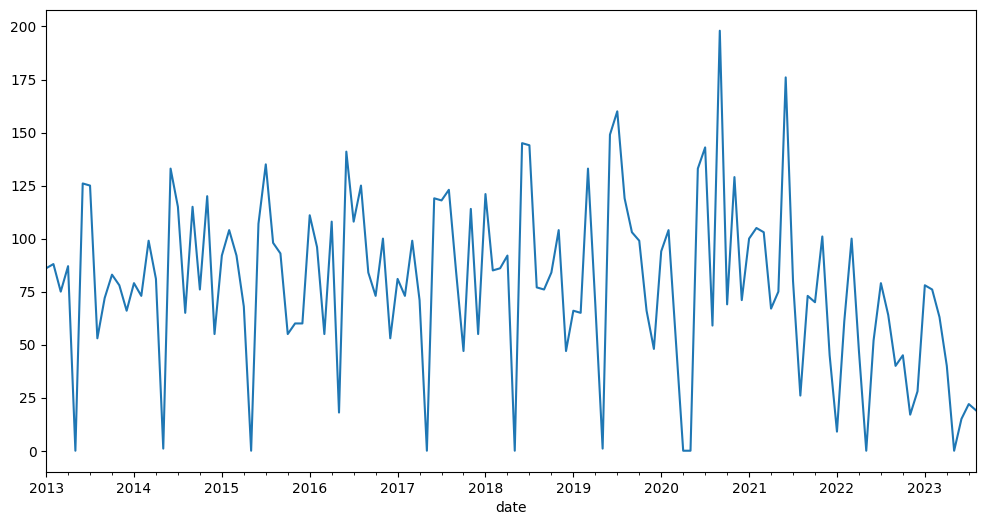

In [11]:
df.resample('M', on='date').case_no.count().plot(x='date', figsize=(12,6))

## Filter by current justices

We only want the decisions penned by current Supreme Court justices. We first make a list of these justices based on the existing dataframe and then filter them out.

In [12]:
df.ponente.value_counts().to_frame().sort_index()

,ponente
A REYES JR J,51
ABAD J,34
BERSAMIN CJ,41
BERSAMIN J,367
BRION J,344
CAGUIOA J,509
CARANDANG J,204
CARPIO J,237
DEL CASTILLO J,571
DELOS SANTOS J,115


In [13]:
justices = ['LEONEN J', 'LEONEN SAJ', 'CAGUIOA J', 'GESMUNDO J', 'GESMUNDO CJ', 'HERNANDO J', 'LAZARO-JAVIER AC J',
          'LAZARO-JAVIER J', 'INTING J', 'ZALAMEDA J', 'ZALAMEDA RV J', 'LOPEZ J', 'LOPEZ J J', 'LOPEZ M J',
          'GAERLAN J', 'GAERLAN SH J', 'ROSARIO J', 'DIMAAMPAO J', 'MARQUEZ J', 'KHO JR J', 'SINGH J',
          'PER CURIAM']

In [14]:
incumbents = df[df['ponente'].isin(justices)]
incumbents

,case_no,title,date,case_link,division,ponente
32,A.M. No. P-12-3099,"OFFICE OF THE COURT ADMINISTRATOR, COMPLAINANT...",2013-01-15,https://elibrary.judiciary.gov.ph/thebookshelf...,EN BANC,PER CURIAM
101,A.M. OCA-IPI No. 07-2618-RTJ,"EDUARDO PANES, JR., JOSEPHINE J. COSEP, ROGER ...",2013-02-12,https://elibrary.judiciary.gov.ph/thebookshelf...,EN BANC,PER CURIAM
116,G.R. No. 197299,"OFFICE OF THE OMBUDSMAN, PETITIONER, VS. RODRI...",2013-02-13,https://elibrary.judiciary.gov.ph/thebookshelf...,SECOND DIVISION,PER CURIAM
129,G.R. No. 204528,"SECRETARY LEILA M. DE LIMA, DIRECTOR NONNATUS ...",2013-02-19,https://elibrary.judiciary.gov.ph/thebookshelf...,EN BANC,LEONEN J
208,A.M. No. MTJ-12-1817 [Formerly A.M. No. 09-2-3...,"OFFICE OF THE COURT ADMINISTRATOR, COMPLAINANT...",2013-03-12,https://elibrary.judiciary.gov.ph/thebookshelf...,EN BANC,PER CURIAM
...,...,...,...,...,...,...
10185,G.R. No. 258257,"PEDRO ""PEPE"" TALISAY, PETITIONER, VS. PEOPLE O...",2023-08-09,https://elibrary.judiciary.gov.ph/thebookshelf...,FIRST DIVISION,GESMUNDO CJ
10186,G.R. No. 262197,"PEOPLE OF THE PHILIPPINES, PLAINTIFF-APPELLEE,...",2023-08-14,https://elibrary.judiciary.gov.ph/thebookshelf...,SECOND DIVISION,LOPEZ J J
10187,A.C. No. 8471,JUDGE RAY ALAN T. DRILON AND ATTY. CORAZON P. ...,2023-08-22,https://elibrary.judiciary.gov.ph/thebookshelf...,EN BANC,PER CURIAM
10188,A.C. No. 12443,"BERNALDO E. VALDEZ, COMPLAINANT, VS. ATTY. WIN...",2023-08-23,https://elibrary.judiciary.gov.ph/thebookshelf...,SPECIAL SECOND DIVISION,ZALAMEDA J


In [15]:
incumbents.ponente.value_counts()

LEONEN J              753
CAGUIOA J             509
HERNANDO J            403
INTING J              396
PER CURIAM            381
LAZARO-JAVIER J       290
GAERLAN J             187
LOPEZ J J             150
ZALAMEDA J            116
GESMUNDO J             83
LOPEZ M J              82
LOPEZ J                73
LEONEN SAJ             69
GESMUNDO CJ            47
KHO JR J               36
ROSARIO J              28
DIMAAMPAO J            26
SINGH J                25
ZALAMEDA RV J           2
GAERLAN SH J            2
MARQUEZ J               2
LAZARO-JAVIER AC J      1
Name: ponente, dtype: int64

In [16]:
incumbents = incumbents.reset_index(drop=True)
incumbents

,case_no,title,date,case_link,division,ponente
0,A.M. No. P-12-3099,"OFFICE OF THE COURT ADMINISTRATOR, COMPLAINANT...",2013-01-15,https://elibrary.judiciary.gov.ph/thebookshelf...,EN BANC,PER CURIAM
1,A.M. OCA-IPI No. 07-2618-RTJ,"EDUARDO PANES, JR., JOSEPHINE J. COSEP, ROGER ...",2013-02-12,https://elibrary.judiciary.gov.ph/thebookshelf...,EN BANC,PER CURIAM
2,G.R. No. 197299,"OFFICE OF THE OMBUDSMAN, PETITIONER, VS. RODRI...",2013-02-13,https://elibrary.judiciary.gov.ph/thebookshelf...,SECOND DIVISION,PER CURIAM
3,G.R. No. 204528,"SECRETARY LEILA M. DE LIMA, DIRECTOR NONNATUS ...",2013-02-19,https://elibrary.judiciary.gov.ph/thebookshelf...,EN BANC,LEONEN J
4,A.M. No. MTJ-12-1817 [Formerly A.M. No. 09-2-3...,"OFFICE OF THE COURT ADMINISTRATOR, COMPLAINANT...",2013-03-12,https://elibrary.judiciary.gov.ph/thebookshelf...,EN BANC,PER CURIAM
...,...,...,...,...,...,...
3656,G.R. No. 258257,"PEDRO ""PEPE"" TALISAY, PETITIONER, VS. PEOPLE O...",2023-08-09,https://elibrary.judiciary.gov.ph/thebookshelf...,FIRST DIVISION,GESMUNDO CJ
3657,G.R. No. 262197,"PEOPLE OF THE PHILIPPINES, PLAINTIFF-APPELLEE,...",2023-08-14,https://elibrary.judiciary.gov.ph/thebookshelf...,SECOND DIVISION,LOPEZ J J
3658,A.C. No. 8471,JUDGE RAY ALAN T. DRILON AND ATTY. CORAZON P. ...,2023-08-22,https://elibrary.judiciary.gov.ph/thebookshelf...,EN BANC,PER CURIAM
3659,A.C. No. 12443,"BERNALDO E. VALDEZ, COMPLAINANT, VS. ATTY. WIN...",2023-08-23,https://elibrary.judiciary.gov.ph/thebookshelf...,SPECIAL SECOND DIVISION,ZALAMEDA J


## Clean ponente column

We will now clean the ponente column. The Supreme Court website does a bad job at making sure the names of the justices are consistent across all decisions they penned. We will now make sure that we join duplicates of these names so we can make proper analysis later.

We start first by looking at the existing names in our list.

In [17]:
incumbents.ponente.value_counts()

LEONEN J              753
CAGUIOA J             509
HERNANDO J            403
INTING J              396
PER CURIAM            381
LAZARO-JAVIER J       290
GAERLAN J             187
LOPEZ J J             150
ZALAMEDA J            116
GESMUNDO J             83
LOPEZ M J              82
LOPEZ J                73
LEONEN SAJ             69
GESMUNDO CJ            47
KHO JR J               36
ROSARIO J              28
DIMAAMPAO J            26
SINGH J                25
ZALAMEDA RV J           2
GAERLAN SH J            2
MARQUEZ J               2
LAZARO-JAVIER AC J      1
Name: ponente, dtype: int64

In [18]:
incumbents.ponente = incumbents.ponente.str.strip()
incumbents

,case_no,title,date,case_link,division,ponente
0,A.M. No. P-12-3099,"OFFICE OF THE COURT ADMINISTRATOR, COMPLAINANT...",2013-01-15,https://elibrary.judiciary.gov.ph/thebookshelf...,EN BANC,PER CURIAM
1,A.M. OCA-IPI No. 07-2618-RTJ,"EDUARDO PANES, JR., JOSEPHINE J. COSEP, ROGER ...",2013-02-12,https://elibrary.judiciary.gov.ph/thebookshelf...,EN BANC,PER CURIAM
2,G.R. No. 197299,"OFFICE OF THE OMBUDSMAN, PETITIONER, VS. RODRI...",2013-02-13,https://elibrary.judiciary.gov.ph/thebookshelf...,SECOND DIVISION,PER CURIAM
3,G.R. No. 204528,"SECRETARY LEILA M. DE LIMA, DIRECTOR NONNATUS ...",2013-02-19,https://elibrary.judiciary.gov.ph/thebookshelf...,EN BANC,LEONEN J
4,A.M. No. MTJ-12-1817 [Formerly A.M. No. 09-2-3...,"OFFICE OF THE COURT ADMINISTRATOR, COMPLAINANT...",2013-03-12,https://elibrary.judiciary.gov.ph/thebookshelf...,EN BANC,PER CURIAM
...,...,...,...,...,...,...
3656,G.R. No. 258257,"PEDRO ""PEPE"" TALISAY, PETITIONER, VS. PEOPLE O...",2023-08-09,https://elibrary.judiciary.gov.ph/thebookshelf...,FIRST DIVISION,GESMUNDO CJ
3657,G.R. No. 262197,"PEOPLE OF THE PHILIPPINES, PLAINTIFF-APPELLEE,...",2023-08-14,https://elibrary.judiciary.gov.ph/thebookshelf...,SECOND DIVISION,LOPEZ J J
3658,A.C. No. 8471,JUDGE RAY ALAN T. DRILON AND ATTY. CORAZON P. ...,2023-08-22,https://elibrary.judiciary.gov.ph/thebookshelf...,EN BANC,PER CURIAM
3659,A.C. No. 12443,"BERNALDO E. VALDEZ, COMPLAINANT, VS. ATTY. WIN...",2023-08-23,https://elibrary.judiciary.gov.ph/thebookshelf...,SPECIAL SECOND DIVISION,ZALAMEDA J


In [19]:
incumbents.ponente = incumbents.ponente.str.replace('LEONEN J', 'Marvic Leonen', regex=False)
incumbents.ponente = incumbents.ponente.str.replace('LEONEN SAJ', 'Marvic Leonen', regex=False)
incumbents.ponente = incumbents.ponente.str.replace('CAGUIOA J', 'Alfredo Caguioa', regex=False)
incumbents.ponente = incumbents.ponente.str.replace('HERNANDO J', 'Ramon Paul Hernando', regex=False)
incumbents.ponente = incumbents.ponente.str.replace('INTING J', 'Henri Jean Paul Inting', regex=False)
incumbents.ponente = incumbents.ponente.str.replace('LAZARO-JAVIER J', 'Amy Lazaro-Javier', regex=False)
incumbents.ponente = incumbents.ponente.str.replace('LAZARO-JAVIER AC J', 'Amy Lazaro-Javier', regex=False)
incumbents.ponente = incumbents.ponente.str.replace('GESMUNDO J', 'Alexander Gesmundo', regex=False)
incumbents.ponente = incumbents.ponente.str.replace('GESMUNDO CJ', 'Alexander Gesmundo', regex=False)
incumbents.ponente = incumbents.ponente.str.replace('DIMAAMPAO J', 'Japar Dimaampao', regex=False)
incumbents.ponente = incumbents.ponente.str.replace('GAERLAN J', 'Samuel Gaerlan', regex=False)
incumbents.ponente = incumbents.ponente.str.replace('GAERLAN SH J', 'Samuel Gaerlan', regex=False)
incumbents.ponente = incumbents.ponente.str.replace('SINGH J', 'Filomena Singh', regex=False)
incumbents.ponente = incumbents.ponente.str.replace('KHO JR J', 'Antonio Kho Jr.', regex=False)
incumbents.ponente = incumbents.ponente.str.replace('ROSARIO J', 'Ricardo Rosario', regex=False)
incumbents.ponente = incumbents.ponente.str.replace('ZALAMEDA J', 'Rodil Zalameda', regex=False)
incumbents.ponente = incumbents.ponente.str.replace('ZALAMEDA RV J', 'Rodil Zalameda', regex=False)
incumbents.ponente = incumbents.ponente.str.replace('MARQUEZ J', 'Midas Marquez', regex=False)
incumbents

,case_no,title,date,case_link,division,ponente
0,A.M. No. P-12-3099,"OFFICE OF THE COURT ADMINISTRATOR, COMPLAINANT...",2013-01-15,https://elibrary.judiciary.gov.ph/thebookshelf...,EN BANC,PER CURIAM
1,A.M. OCA-IPI No. 07-2618-RTJ,"EDUARDO PANES, JR., JOSEPHINE J. COSEP, ROGER ...",2013-02-12,https://elibrary.judiciary.gov.ph/thebookshelf...,EN BANC,PER CURIAM
2,G.R. No. 197299,"OFFICE OF THE OMBUDSMAN, PETITIONER, VS. RODRI...",2013-02-13,https://elibrary.judiciary.gov.ph/thebookshelf...,SECOND DIVISION,PER CURIAM
3,G.R. No. 204528,"SECRETARY LEILA M. DE LIMA, DIRECTOR NONNATUS ...",2013-02-19,https://elibrary.judiciary.gov.ph/thebookshelf...,EN BANC,Marvic Leonen
4,A.M. No. MTJ-12-1817 [Formerly A.M. No. 09-2-3...,"OFFICE OF THE COURT ADMINISTRATOR, COMPLAINANT...",2013-03-12,https://elibrary.judiciary.gov.ph/thebookshelf...,EN BANC,PER CURIAM
...,...,...,...,...,...,...
3656,G.R. No. 258257,"PEDRO ""PEPE"" TALISAY, PETITIONER, VS. PEOPLE O...",2023-08-09,https://elibrary.judiciary.gov.ph/thebookshelf...,FIRST DIVISION,Alexander Gesmundo
3657,G.R. No. 262197,"PEOPLE OF THE PHILIPPINES, PLAINTIFF-APPELLEE,...",2023-08-14,https://elibrary.judiciary.gov.ph/thebookshelf...,SECOND DIVISION,LOPEZ J J
3658,A.C. No. 8471,JUDGE RAY ALAN T. DRILON AND ATTY. CORAZON P. ...,2023-08-22,https://elibrary.judiciary.gov.ph/thebookshelf...,EN BANC,PER CURIAM
3659,A.C. No. 12443,"BERNALDO E. VALDEZ, COMPLAINANT, VS. ATTY. WIN...",2023-08-23,https://elibrary.judiciary.gov.ph/thebookshelf...,SPECIAL SECOND DIVISION,Rodil Zalameda


In [20]:
incumbents.ponente.value_counts()

Marvic Leonen             822
Alfredo Caguioa           509
Ramon Paul Hernando       403
Henri Jean Paul Inting    396
PER CURIAM                381
Amy Lazaro-Javier         291
Samuel Gaerlan            189
LOPEZ J J                 150
Alexander Gesmundo        130
Rodil Zalameda            118
LOPEZ M J                  82
LOPEZ J                    73
Antonio Kho Jr.            36
Ricardo Rosario            28
Japar Dimaampao            26
Filomena Singh             25
Midas Marquez               2
Name: ponente, dtype: int64

In [21]:
incumbents.ponente = incumbents.ponente.str.replace(r'[LOPEZ] M', 'Mario Lopez', regex=True)
incumbents.ponente = incumbents.ponente.str.replace('LOPEMario Lopez J', 'Mario Lopez', regex=True)
incumbents.ponente = incumbents.ponente.str.replace(r'[LOPEZ] J J', 'Jhosep Lopez', regex=True)
incumbents.ponente = incumbents.ponente.str.replace('LOPEJhosep Lopez', 'Jhosep Lopez', regex=True)
incumbents.ponente = incumbents.ponente.str.replace('LOPEZ J', 'Mario Lopez', regex=True)
incumbents.ponente.value_counts()

Marvic Leonen             822
Alfredo Caguioa           509
Ramon Paul Hernando       403
Henri Jean Paul Inting    396
PER CURIAM                381
Amy Lazaro-Javier         291
Samuel Gaerlan            189
Mario Lopez               155
Jhosep Lopez              150
Alexander Gesmundo        130
Rodil Zalameda            118
Antonio Kho Jr.            36
Ricardo Rosario            28
Japar Dimaampao            26
Filomena Singh             25
Midas Marquez               2
Name: ponente, dtype: int64

## Final check

Now that we cleaned the ponente column, let's do a final check before the analysis proper. Your final dataframe should look like something below

In [22]:
incumbents

,case_no,title,date,case_link,division,ponente
0,A.M. No. P-12-3099,"OFFICE OF THE COURT ADMINISTRATOR, COMPLAINANT...",2013-01-15,https://elibrary.judiciary.gov.ph/thebookshelf...,EN BANC,PER CURIAM
1,A.M. OCA-IPI No. 07-2618-RTJ,"EDUARDO PANES, JR., JOSEPHINE J. COSEP, ROGER ...",2013-02-12,https://elibrary.judiciary.gov.ph/thebookshelf...,EN BANC,PER CURIAM
2,G.R. No. 197299,"OFFICE OF THE OMBUDSMAN, PETITIONER, VS. RODRI...",2013-02-13,https://elibrary.judiciary.gov.ph/thebookshelf...,SECOND DIVISION,PER CURIAM
3,G.R. No. 204528,"SECRETARY LEILA M. DE LIMA, DIRECTOR NONNATUS ...",2013-02-19,https://elibrary.judiciary.gov.ph/thebookshelf...,EN BANC,Marvic Leonen
4,A.M. No. MTJ-12-1817 [Formerly A.M. No. 09-2-3...,"OFFICE OF THE COURT ADMINISTRATOR, COMPLAINANT...",2013-03-12,https://elibrary.judiciary.gov.ph/thebookshelf...,EN BANC,PER CURIAM
...,...,...,...,...,...,...
3656,G.R. No. 258257,"PEDRO ""PEPE"" TALISAY, PETITIONER, VS. PEOPLE O...",2023-08-09,https://elibrary.judiciary.gov.ph/thebookshelf...,FIRST DIVISION,Alexander Gesmundo
3657,G.R. No. 262197,"PEOPLE OF THE PHILIPPINES, PLAINTIFF-APPELLEE,...",2023-08-14,https://elibrary.judiciary.gov.ph/thebookshelf...,SECOND DIVISION,Jhosep Lopez
3658,A.C. No. 8471,JUDGE RAY ALAN T. DRILON AND ATTY. CORAZON P. ...,2023-08-22,https://elibrary.judiciary.gov.ph/thebookshelf...,EN BANC,PER CURIAM
3659,A.C. No. 12443,"BERNALDO E. VALDEZ, COMPLAINANT, VS. ATTY. WIN...",2023-08-23,https://elibrary.judiciary.gov.ph/thebookshelf...,SPECIAL SECOND DIVISION,Rodil Zalameda


## Analysis proper

We're now ready to make simple analysis on this.

In [23]:
incumbents.dtypes

case_no              object
title                object
date         datetime64[ns]
case_link            object
division             object
ponente              object
dtype: object

## Number of decisions promulgated by month

<AxesSubplot:xlabel='date'>

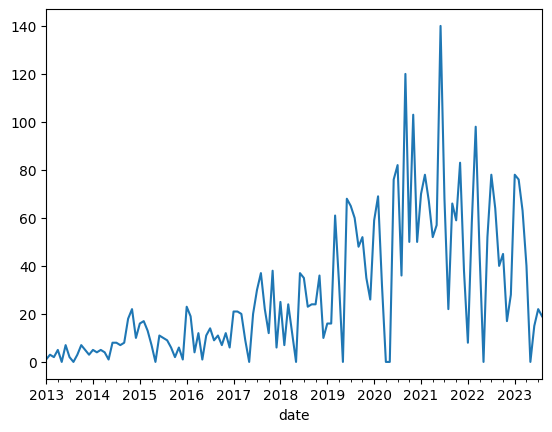

In [24]:
incumbents.resample('M', on='date').case_no.count().plot()

## Number of decisions written per justice

<AxesSubplot:>

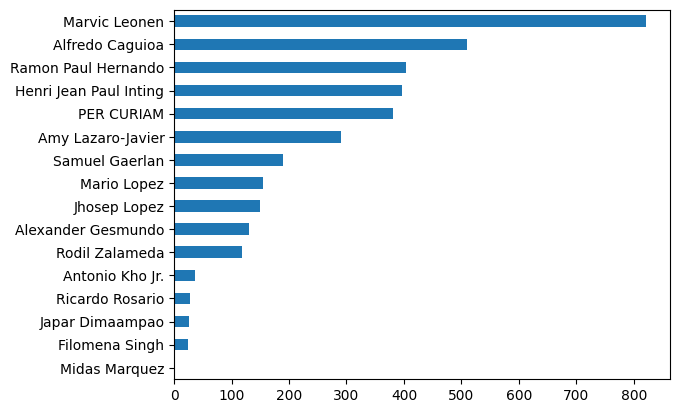

In [25]:
incumbents.ponente.value_counts(ascending=True).plot(kind='barh')

## Decisions by justice, by month

In [26]:
by_justice = incumbents.groupby('ponente').resample('M', on='date').case_no.count().to_frame().reset_index()
by_justice

,ponente,date,case_no
0,Alexander Gesmundo,2017-11-30,2
1,Alexander Gesmundo,2017-12-31,1
2,Alexander Gesmundo,2018-01-31,4
3,Alexander Gesmundo,2018-02-28,1
4,Alexander Gesmundo,2018-03-31,3
...,...,...,...
789,Samuel Gaerlan,2023-04-30,3
790,Samuel Gaerlan,2023-05-31,0
791,Samuel Gaerlan,2023-06-30,1
792,Samuel Gaerlan,2023-07-31,2


In [27]:
by_justice.case_no = by_justice.case_no.astype(float)
by_justice

,ponente,date,case_no
0,Alexander Gesmundo,2017-11-30,2.0
1,Alexander Gesmundo,2017-12-31,1.0
2,Alexander Gesmundo,2018-01-31,4.0
3,Alexander Gesmundo,2018-02-28,1.0
4,Alexander Gesmundo,2018-03-31,3.0
...,...,...,...
789,Samuel Gaerlan,2023-04-30,3.0
790,Samuel Gaerlan,2023-05-31,0.0
791,Samuel Gaerlan,2023-06-30,1.0
792,Samuel Gaerlan,2023-07-31,2.0


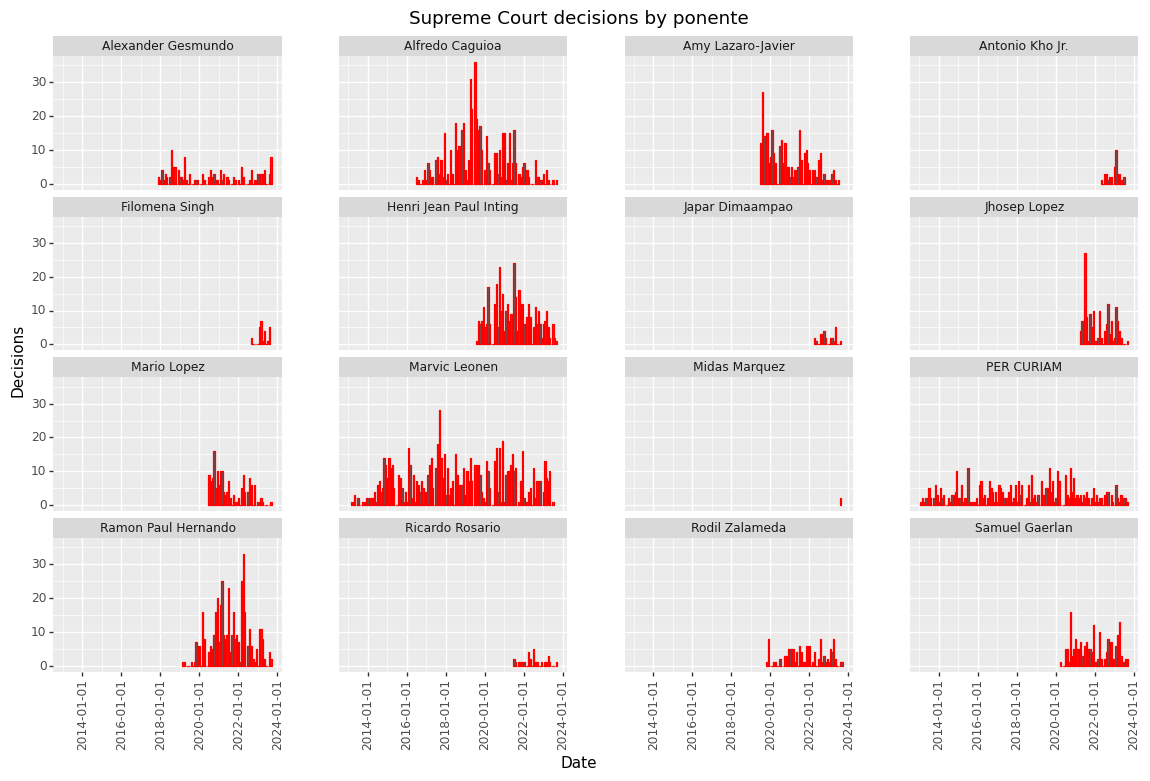

<ggplot: (393522050)>

In [28]:
(
    ggplot(by_justice, aes('date', 'case_no')) +
           geom_col(color="red") +
           theme(figure_size=(14,8)) +
           facet_wrap('ponente') +
           theme(subplots_adjust={'wspace': 0.25}, axis_text_x=element_text(rotation=90)) +
           labs(x= "Date", y="Decisions", title="Supreme Court decisions by ponente")
)

## Average decisions by justice per month in office

Each justice was appointed to office at different ties. So in this part, we control for that in computing the number of decisions they penned.

For this purpose, we have a separate Excel file containing the **number of months in office** of each justice as of August 31, 2023, which is the latest date in our dataframe of decisions.

In [29]:
in_office = pd.read_excel('justice term in office as of Aug. 2023.xlsx')
in_office

,ponente,months_in_office
0,Marvic Leonen,129
1,Alfredo Caguioa,91
2,Ramon Paul Hernando,58
3,Amy Lazaro-Javier,53
4,Henri Jean Paul Inting,51
5,Rodil Zalameda,48
6,Mario Lopez,44
7,Samuel Gaerlan,43
8,Ricardo Rosario,34
9,Jhosep Lopez,31


We generated then a new dataframe containing the number of decisions written by each justice to date. We will merge this with our **in_office** df.

In [30]:
decisions_to_date = incumbents.ponente.value_counts().to_frame().reset_index()
decisions_to_date

,index,ponente
0,Marvic Leonen,822
1,Alfredo Caguioa,509
2,Ramon Paul Hernando,403
3,Henri Jean Paul Inting,396
4,PER CURIAM,381
5,Amy Lazaro-Javier,291
6,Samuel Gaerlan,189
7,Mario Lopez,155
8,Jhosep Lopez,150
9,Alexander Gesmundo,130


In [31]:
decisions_to_date = decisions_to_date.drop(4, axis=0)
decisions_to_date

,index,ponente
0,Marvic Leonen,822
1,Alfredo Caguioa,509
2,Ramon Paul Hernando,403
3,Henri Jean Paul Inting,396
5,Amy Lazaro-Javier,291
6,Samuel Gaerlan,189
7,Mario Lopez,155
8,Jhosep Lopez,150
9,Alexander Gesmundo,130
10,Rodil Zalameda,118


In [32]:
decisions_to_date.columns = ['ponente', 'decisions']
decisions_to_date

,ponente,decisions
0,Marvic Leonen,822
1,Alfredo Caguioa,509
2,Ramon Paul Hernando,403
3,Henri Jean Paul Inting,396
5,Amy Lazaro-Javier,291
6,Samuel Gaerlan,189
7,Mario Lopez,155
8,Jhosep Lopez,150
9,Alexander Gesmundo,130
10,Rodil Zalameda,118


In [33]:
merged= decisions_to_date.merge(in_office, how='left')
merged

,ponente,decisions,months_in_office
0,Marvic Leonen,822,129
1,Alfredo Caguioa,509,91
2,Ramon Paul Hernando,403,58
3,Henri Jean Paul Inting,396,51
4,Amy Lazaro-Javier,291,53
5,Samuel Gaerlan,189,43
6,Mario Lopez,155,44
7,Jhosep Lopez,150,31
8,Alexander Gesmundo,130,28
9,Rodil Zalameda,118,48


In [34]:
merged['ave_decision_per_month'] = merged.decisions / merged.months_in_office
merged.ave_decision_per_month = merged.ave_decision_per_month.round(2)
merged

,ponente,decisions,months_in_office,ave_decision_per_month
0,Marvic Leonen,822,129,6.37
1,Alfredo Caguioa,509,91,5.59
2,Ramon Paul Hernando,403,58,6.95
3,Henri Jean Paul Inting,396,51,7.76
4,Amy Lazaro-Javier,291,53,5.49
5,Samuel Gaerlan,189,43,4.40
6,Mario Lopez,155,44,3.52
7,Jhosep Lopez,150,31,4.84
8,Alexander Gesmundo,130,28,4.64
9,Rodil Zalameda,118,48,2.46


In [35]:
merged = merged.sort_values('ave_decision_per_month', ascending=False)
merged

,ponente,decisions,months_in_office,ave_decision_per_month
3,Henri Jean Paul Inting,396,51,7.76
2,Ramon Paul Hernando,403,58,6.95
0,Marvic Leonen,822,129,6.37
1,Alfredo Caguioa,509,91,5.59
4,Amy Lazaro-Javier,291,53,5.49
7,Jhosep Lopez,150,31,4.84
8,Alexander Gesmundo,130,28,4.64
5,Samuel Gaerlan,189,43,4.40
6,Mario Lopez,155,44,3.52
9,Rodil Zalameda,118,48,2.46


<AxesSubplot:ylabel='ponente'>

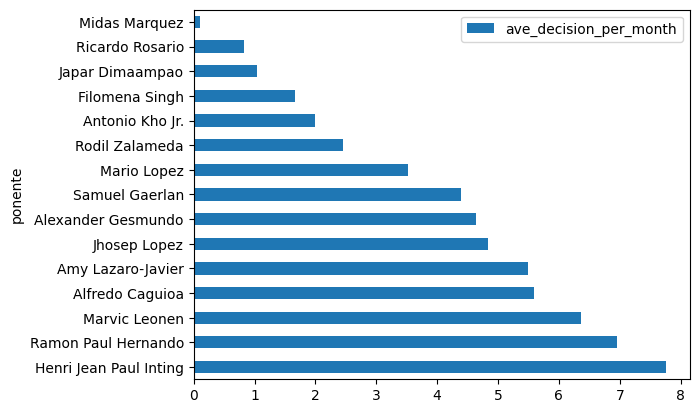

In [36]:
merged.plot(y='ave_decision_per_month', x='ponente', kind='barh')

## Decisions by division

How many cases are decided by the full court?

In [37]:
by_division = incumbents.groupby('division').resample('M', on='date').case_no.count().to_frame().reset_index()
by_division

,division,date,case_no
0,EN BANC,2013-01-31,1
1,EN BANC,2013-02-28,2
2,EN BANC,2013-03-31,2
3,EN BANC,2013-04-30,4
4,EN BANC,2013-05-31,0
...,...,...,...
712,THIRD DIVISION,2023-04-30,14
713,THIRD DIVISION,2023-05-31,0
714,THIRD DIVISION,2023-06-30,9
715,THIRD DIVISION,2023-07-31,7


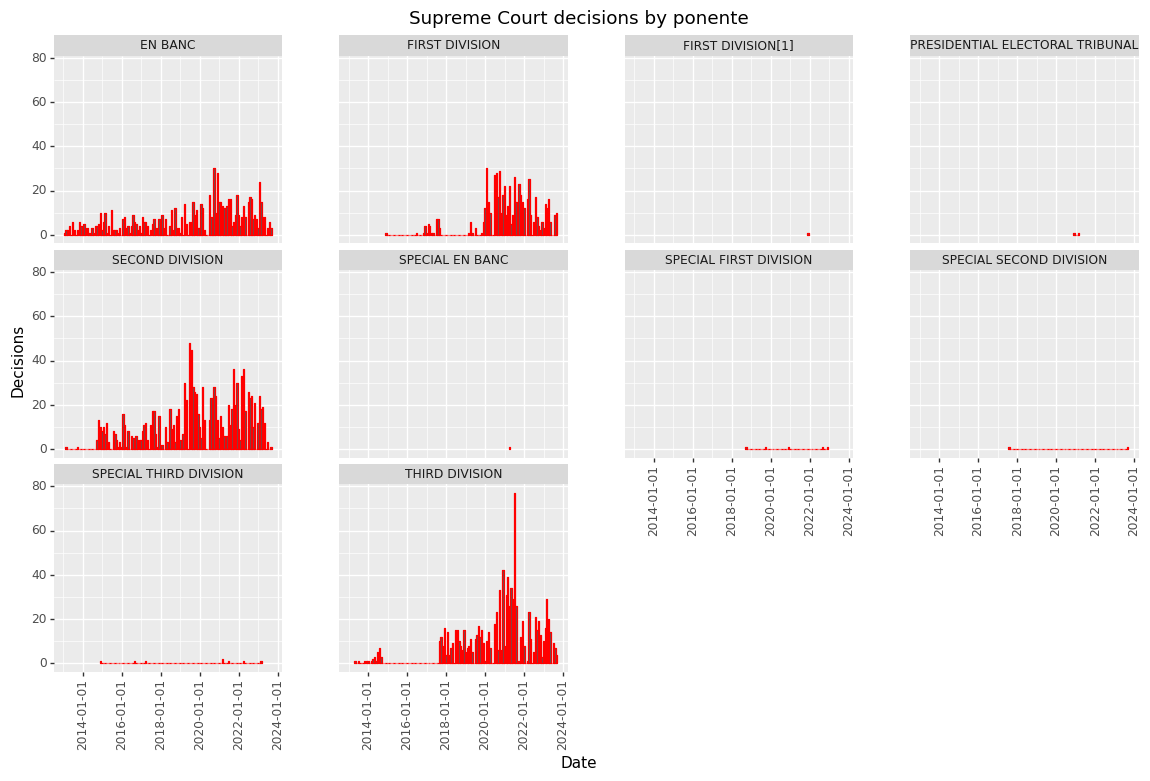

<ggplot: (704710431)>

In [38]:
(
    ggplot(by_division, aes('date', 'case_no')) +
           geom_col(color="red") +
           theme(figure_size=(14,8)) +
           facet_wrap('division') +
           theme(subplots_adjust={'wspace': 0.25}, axis_text_x=element_text(rotation=90)) +
           labs(x= "Date", y="Decisions", title="Supreme Court decisions by ponente")
)

## Decisions by the en banc (full court)

In [39]:
en_banc = incumbents[incumbents.division=='EN BANC'].reset_index(drop=True)
en_banc

,case_no,title,date,case_link,division,ponente
0,A.M. No. P-12-3099,"OFFICE OF THE COURT ADMINISTRATOR, COMPLAINANT...",2013-01-15,https://elibrary.judiciary.gov.ph/thebookshelf...,EN BANC,PER CURIAM
1,A.M. OCA-IPI No. 07-2618-RTJ,"EDUARDO PANES, JR., JOSEPHINE J. COSEP, ROGER ...",2013-02-12,https://elibrary.judiciary.gov.ph/thebookshelf...,EN BANC,PER CURIAM
2,G.R. No. 204528,"SECRETARY LEILA M. DE LIMA, DIRECTOR NONNATUS ...",2013-02-19,https://elibrary.judiciary.gov.ph/thebookshelf...,EN BANC,Marvic Leonen
3,A.M. No. MTJ-12-1817 [Formerly A.M. No. 09-2-3...,"OFFICE OF THE COURT ADMINISTRATOR, COMPLAINANT...",2013-03-12,https://elibrary.judiciary.gov.ph/thebookshelf...,EN BANC,PER CURIAM
4,G.R. No. 204123,"MARIA LOURDES B. LOCSIN, PETITIONER, VS. HOUSE...",2013-03-19,https://elibrary.judiciary.gov.ph/thebookshelf...,EN BANC,Marvic Leonen
...,...,...,...,...,...,...
804,A.M. No. 23-05-05-SC,REQUEST OF THE PUBLIC ATTORNEY'S OFFICE TO DEL...,2023-07-11,https://elibrary.judiciary.gov.ph/thebookshelf...,EN BANC,Filomena Singh
805,G.R. No. 229471,"PACIFIC CEMENT COMPANY, PETITIONER, VS. OIL AN...",2023-07-11,https://elibrary.judiciary.gov.ph/thebookshelf...,EN BANC,Alexander Gesmundo
806,G.R. No. 260650,"ROBERTO ""PINPIN"" T. UY, JR., PETITIONER, VS. C...",2023-08-08,https://elibrary.judiciary.gov.ph/thebookshelf...,EN BANC,Mario Lopez
807,G.R. No. 264029,"JOENAR VARGAS AGRAVANTE, PETITIONER, VS. COMMI...",2023-08-08,https://elibrary.judiciary.gov.ph/thebookshelf...,EN BANC,Alexander Gesmundo


### Monthly from 2013

In [49]:
en_banc_count_monthly = en_banc.resample('M', on='date').case_no.count().to_frame().reset_index()
en_banc_count_monthly

,date,case_no
0,2013-01-31,1
1,2013-02-28,2
2,2013-03-31,2
3,2013-04-30,4
4,2013-05-31,0
...,...,...
123,2023-04-30,8
124,2023-05-31,0
125,2023-06-30,3
126,2023-07-31,6


<AxesSubplot:xlabel='date'>

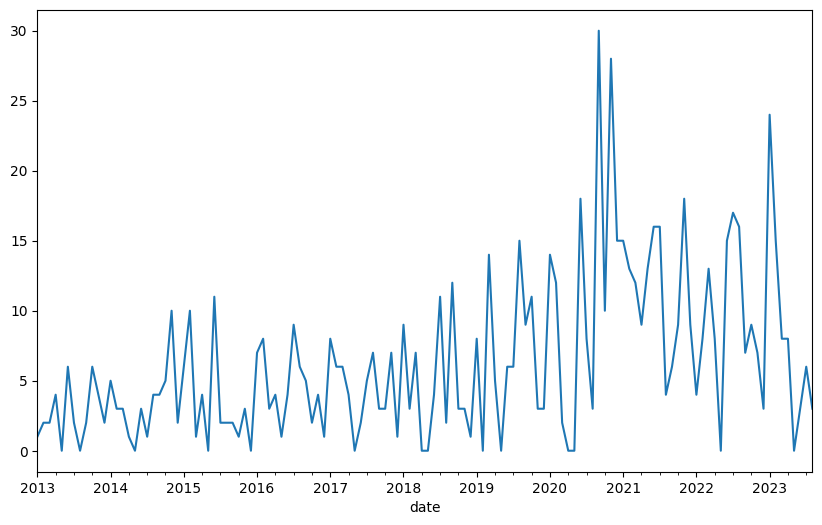

In [41]:
en_banc.resample('M', on='date').case_no.count().plot(x='date', figsize=(10,6))
#monthly

### Yearly from 2013

In [50]:
en_banc_count_annual = en_banc.resample('Y', on='date').case_no.count().to_frame().reset_index()
en_banc_count_annual

,date,case_no
0,2013-12-31,31
1,2014-12-31,41
2,2015-12-31,42
3,2016-12-31,54
4,2017-12-31,52
5,2018-12-31,55
6,2019-12-31,80
7,2020-12-31,140
8,2021-12-31,140
9,2022-12-31,107


<AxesSubplot:xlabel='date'>

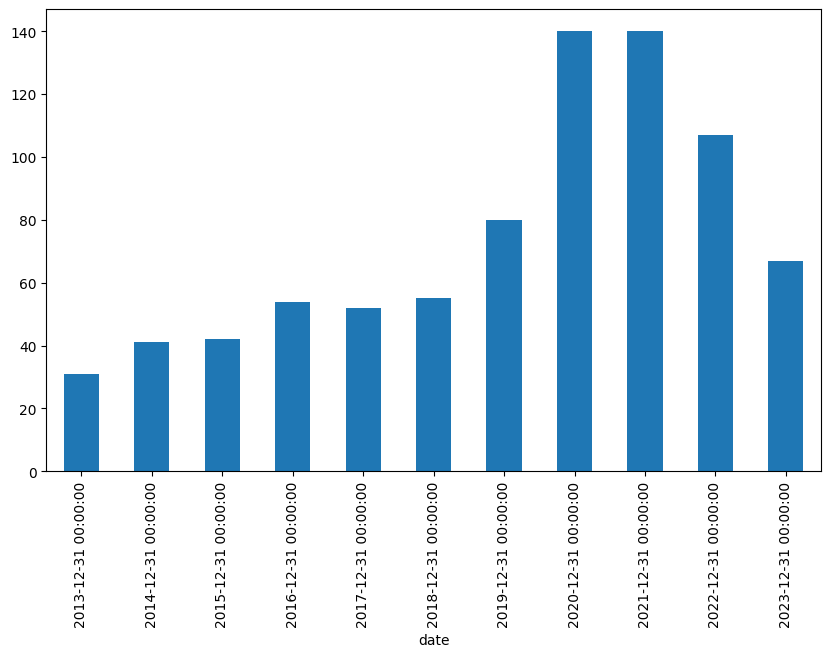

In [48]:
en_banc.resample('Y', on='date').case_no.count().plot(x='date', kind='bar', figsize=(10,6))

In [51]:
pivot = by_justice.pivot_table(columns="ponente", index='date', values='case_no', aggfunc='sum', fill_value='0', dropna=False).reset_index()
pivot.head(10)

ponente,date,Alexander Gesmundo,Alfredo Caguioa,Amy Lazaro-Javier,Antonio Kho Jr.,Filomena Singh,Henri Jean Paul Inting,Japar Dimaampao,Jhosep Lopez,Mario Lopez,Marvic Leonen,Midas Marquez,PER CURIAM,Ramon Paul Hernando,Ricardo Rosario,Rodil Zalameda,Samuel Gaerlan
0,2013-01-31,0,0,0,0,0,0,0,0,0,0,0,1.0,0,0,0,0
1,2013-02-28,0,0,0,0,0,0,0,0,0,1.0,0,2.0,0,0,0,0
2,2013-03-31,0,0,0,0,0,0,0,0,0,1.0,0,1.0,0,0,0,0
3,2013-04-30,0,0,0,0,0,0,0,0,0,3.0,0,2.0,0,0,0,0
4,2013-05-31,0,0,0,0,0,0,0,0,0,0.0,0,0.0,0,0,0,0
5,2013-06-30,0,0,0,0,0,0,0,0,0,2.0,0,5.0,0,0,0,0
6,2013-07-31,0,0,0,0,0,0,0,0,0,0.0,0,2.0,0,0,0,0
7,2013-08-31,0,0,0,0,0,0,0,0,0,0.0,0,0.0,0,0,0,0
8,2013-09-30,0,0,0,0,0,0,0,0,0,1.0,0,2.0,0,0,0,0
9,2013-10-31,0,0,0,0,0,0,0,0,0,1.0,0,6.0,0,0,0,0


## Save data for charting

In [52]:
# merged.to_excel('decision per month.xlsx', index=False)
# en_banc_count.to_excel('en banc decisions.xlsx', index=False)
# pivot.to_excel('decision by justice by month.xlsx', index=False)